# Simple LR on Sent140 Dataset

In [2]:
# utilities
import re
import numpy as np
import pandas as pd
import string

from tqdm import tqdm
tqdm.pandas()


# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import stopwords
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import confusion_matrix, classification_report



#spacy clean text
import spacy #load spacy
nlp = spacy.load("en_core_web_sm", disable=['parser', 'tagger', 'ner'])
stops = stopwords.words("english")
regex_magic= lambda x: ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

def text_preprocessing_spacy(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    out=" ".join(lemmatized)
    out=re.sub(r'http\S+', '', out)
    out=regex_magic(out)
    return out



#functions for printing the results of the Model
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# Training

In [4]:
# Importing the dataset
sent140 = pd.read_csv(r"D:\DTU\Semester 3 - Fall 2020\Social Graphs and Interactions\__Final Project__\Data Proofs\trainingandtestdata\sentiment140.csv",
                      encoding="ISO-8859-1" , names=["sentiment", "ids", "date", "flag", "user", "text"])
#taking the columns that we need
sent140 = sent140[['sentiment','text']]
sent140['sentiment'] = sent140['sentiment'].replace(4,1)
#preprocessing the text
sent140['text_clean']=sent140.text.progress_apply(lambda x: text_preprocessing_spacy(x,True,True))
#sent140['text_clean_join']=sent140.text_clean.progress_apply(lambda x: ' '.join(x))

  0%|          | 0/1600000 [00:00<?, ?it/s]C:\Users\Ben\anaconda3\envs\CryptoSent\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|██████████| 1600000/1600000 [00:02<00:00, 622824.94it/s]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(sent140['text_clean'],
                                                    sent140.sentiment,
                                                    test_size = 0.05, random_state = 42)
word2vec = TfidfVectorizer(ngram_range=(1,2), max_features=50000)
word2vec.fit(X_train)
X_train = word2vec.transform(X_train)
X_test  = word2vec.transform(X_test)

              precision    recall  f1-score   support

           0       0.81      0.77      0.79     39999
           1       0.78      0.81      0.80     40001

    accuracy                           0.79     80000
   macro avg       0.79      0.79      0.79     80000
weighted avg       0.79      0.79      0.79     80000



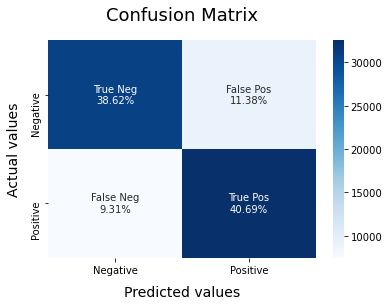

In [9]:
#Linear SVC
clf = LogisticRegression(C=2,n_jobs=-1,max_iter=10000)
#Train the model
clf.fit(X_train, y_train)
model_Evaluate(clf)

In [10]:
# Getting the sentiment of the Tweets
def get_sentiment(text):
    text=word2vec.transform([text])
    neg,pos=clf.predict_proba(text)[0]
    if neg>.6:
        sentiment='Negative'
    elif pos>.6:
        sentiment='Positive'
    else:
        sentiment='Netural'
    return neg,pos,sentiment

list2doc=lambda x: ' '.join(x)

# Fittinng or Reddit Submissions

In [12]:
bit=pd.read_pickle(r'C:\Users\Ben\Desktop\Diplomatiki\CryptoSent\Datasets\Main Dataset\submissions.pickle')


In [45]:
bit.selftext=bit.selftext.fillna(' ')
bit.title=bit.title.fillna(' ')
bit['all_text']=bit.title+' '+bit.selftext

bit.all_text=bit.all_text.progress_apply(lambda x: x.replace('[removed]',''))
bit.all_text=bit.all_text.progress_apply(lambda x: x.replace('[deleted]',''))
save=bit.copy()

100%|██████████| 1559351/1559351 [00:01<00:00, 980397.59it/s]


In [17]:
#bit=save.head(1000)

In [67]:
bit['text_processed']=bit['all_text'].progress_apply(lambda x: text_preprocessing_spacy(x,True,True))


100%|██████████| 1559351/1559351 [1:23:58<00:00, 309.51it/s]


In [68]:
bit['sentiment_scores_lr']=bit.text_processed.progress_apply(get_sentiment)

100%|██████████| 1559351/1559351 [18:06<00:00, 1434.57it/s]


In [69]:
# claculating and normalizing the polarity or in other words the confidence of the model's prediction
pos=bit.sentiment_scores_lr.apply(lambda x: x[1]).tolist()
neg=bit.sentiment_scores_lr.apply(lambda x: x[0]).tolist()
pos_max=max(pos)
pos_min=min(pos)
def normalize_polarity(x):
    avg=(pos_max+pos_min)/2
    ran=(pos_max-pos_min)/2
    return (x-avg)/ran
bit['polarity_lr']=bit.sentiment_scores_lr.progress_apply(lambda x: normalize_polarity(x[1]))
bit['sentiment_lr']=bit.sentiment_scores_lr.apply(lambda x: x[2])

100%|██████████| 1559351/1559351 [00:02<00:00, 749225.63it/s]


In [71]:
bit.to_pickle('subs_lr_sent.pickle')

## bullshiets


In [30]:
btcp=pd.read_csv(r"C:\Users\Ben\Desktop\Diplomatiki\Datasets\BTC_USD_2020-09-13_2021-09-12-CoinDesk.csv")
btcp['Date_index']=pd.to_datetime(btcp.Date)
btcp=btcp.set_index('Date_index')

btcp=btcp['2021':'2021-08']

In [65]:
d1=bit.resample('d').sum()[['polarity']]

In [66]:
df=pd.concat([d1,btcp[['Closing Price (USD)']]],axis=1)
df=df[df.polarity.notna()]
df=df.rename(columns={'Closing Price (USD)':'btc_close'})
df['btc_close_diff']=df.btc_close.diff()

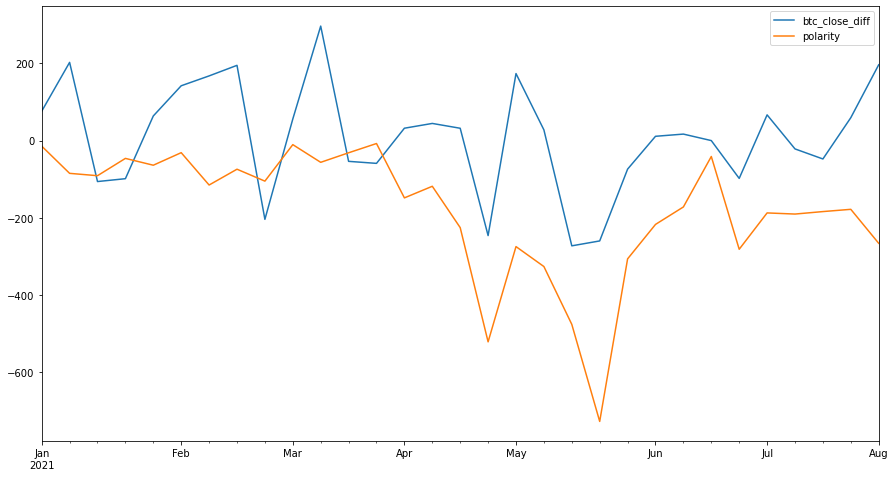

In [74]:
a1=df.resample('w').sum().btc_close_diff/40
a2=df.resample('w').sum().polarity
pd.concat([a1,a2],axis=1).plot(figsize=(15,8));

In [75]:
from scipy import stats
# Y and Z are numpy arrays or lists of variables 
stats.pearsonr(a1.to_list(), a2.to_list())

(0.536471831542825, 0.0018636998703011676)

# desrciptive

In [79]:
bit=bit[['date', 'title', 'body', 'score',
       'num_comments', 'id', 'subreddit', 'submission', 'redditor', 'url',
       'user', 'lang', 'lang_text', 'text', 'text_processed',
       'sentiment_scores', 'polarity', 'sentiment']]

<AxesSubplot:xlabel='Date'>

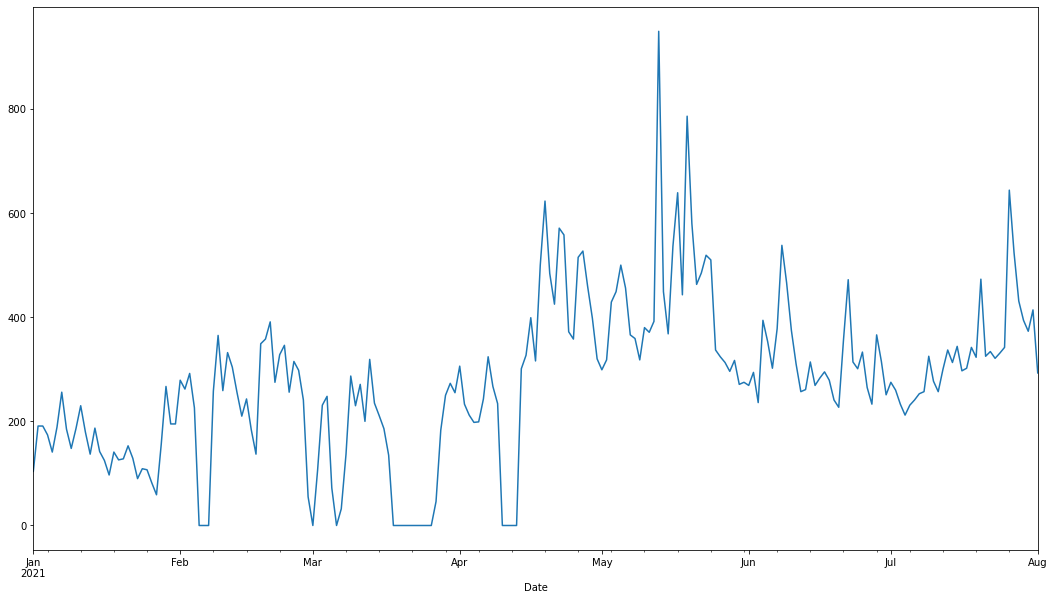

In [117]:
bit.resample('d').id.count().plot(figsize=(18,10))

<AxesSubplot:xlabel='Date'>

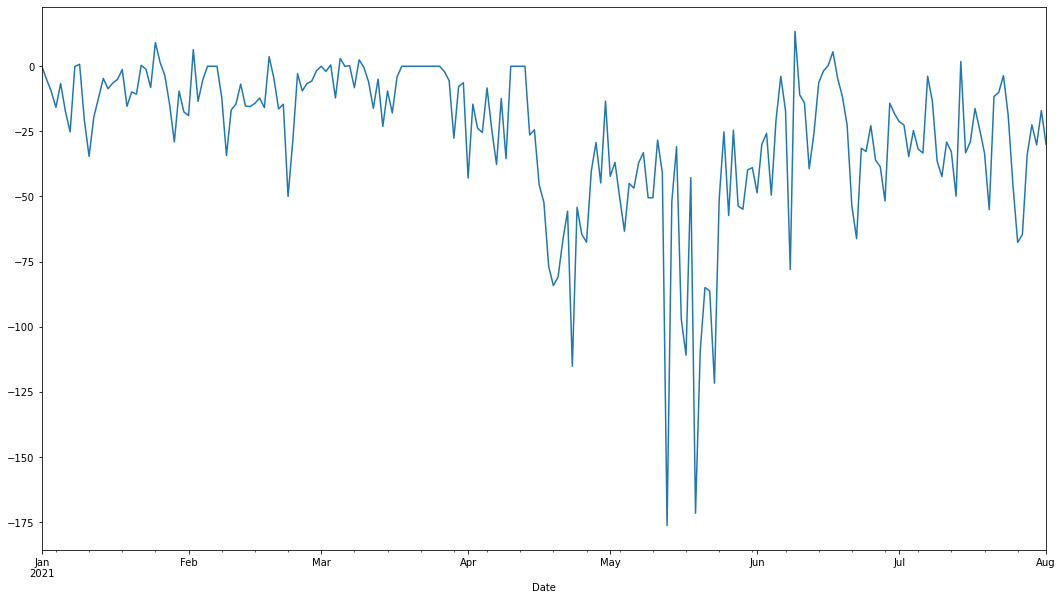

In [120]:
bit.resample('d').polarity.sum().plot(figsize=(18,10))

<AxesSubplot:xlabel='Date_index'>

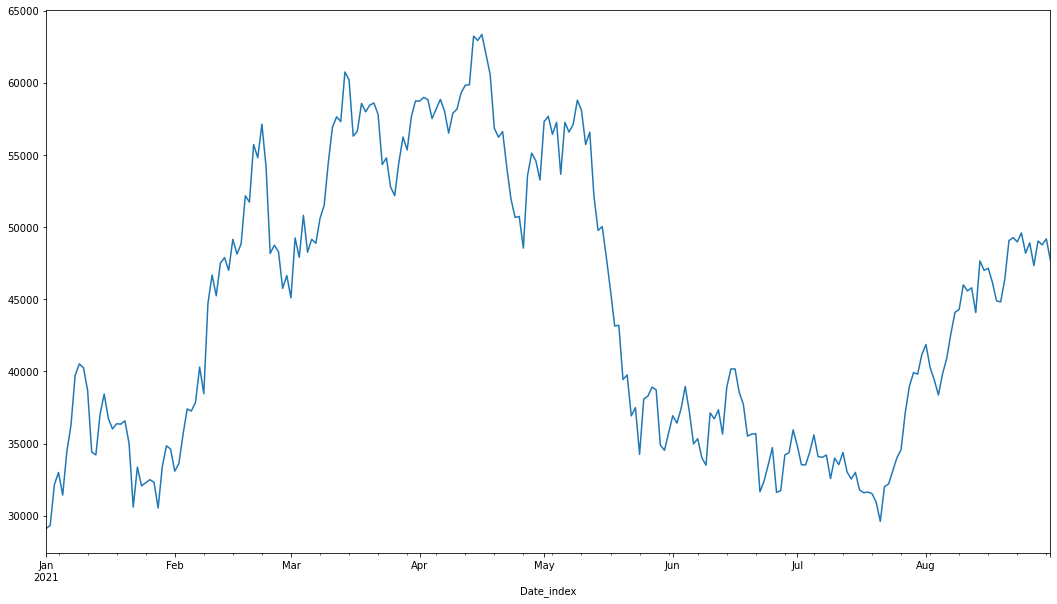

In [124]:
btcp['Closing Price (USD)'].plot(figsize=(18,10))

In [94]:
bit.date=pd.to_datetime(bit.date)

C:\Users\Ben\anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [108]:
bit['dayofweek']=bit.date.dt.day_name()

C:\Users\Ben\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [110]:
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
bit['dayofweek'] = pd.Categorical(bit['dayofweek'], categories=cats, ordered=True)
bit = bit.sort_values('dayofweek')

C:\Users\Ben\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:xlabel='dayofweek'>

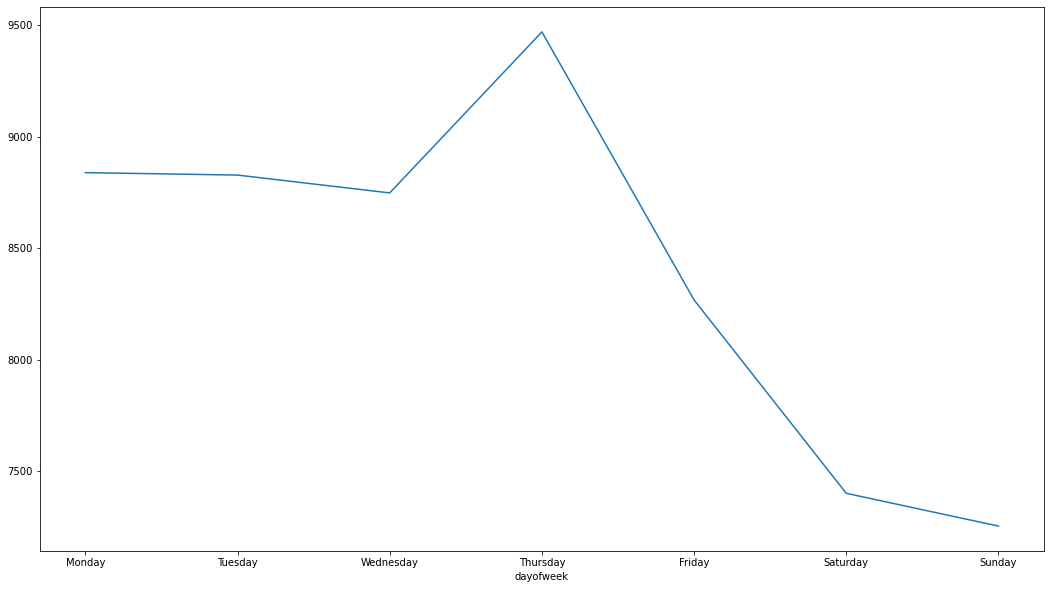

In [115]:
bit.groupby('dayofweek').id.count().plot(figsize=(18,10))

<AxesSubplot:xlabel='dayofweek'>

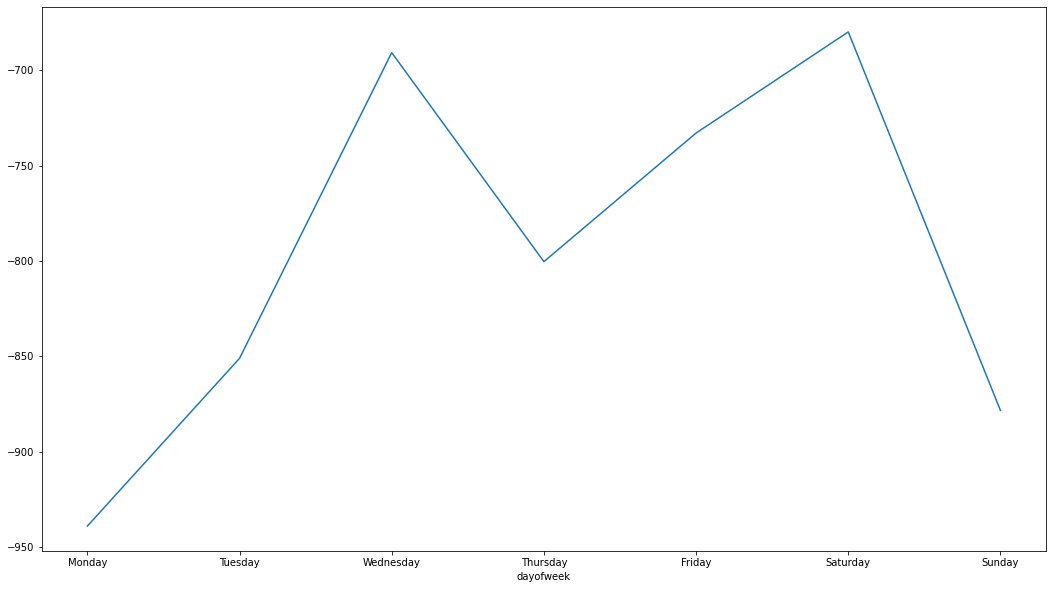

In [119]:
bit.groupby('dayofweek').polarity.sum().plot(figsize=(18,10))

# Additional


In [ ]:

pip install cPickle

import _pickle as cPickle
# save the classifier
with open('my_dumped_classifier.pkl', 'wb') as fid:
    cPickle.dump(clf, fid)    


# load it again
with open('my_dumped_classifier.pkl', 'rb') as fid:
    gnb_loaded = cPickle.load(fid)

In [ ]:

import pandas as pd
import langid
from tqdm import tqdm
tqdm.pandas()
import text2emotion as te


bit=pd.read_csv(r"C:\Users\Ben\Desktop\Diplomatiki\Reddit 101\Trying PRAW\btc_bitcoin_2021_uptoAug.csv")

bit.selftext=bit.body.astype(str)
bit.selftext=bit.body.fillna('NO TEXT')
#bit=bit[bit.selftext!='nan']

#english
bit['lang']=bit.title.progress_apply(langid.classify)
bit['lang_text']=bit.body.fillna('notext').progress_apply(langid.classify)

bit.lang=bit.lang.apply(lambda x: x[0])
bit=bit[bit.lang=='en']

bit.body=bit.body.fillna(' ')
bit['text']=bit.title+bit.body

In [ ]:
# Import spaCy and load the language library
import spacy

nlp = spacy.load('en_core_web_sm')

def text_processing_spacy(text):
    # Create a Doc object
    doc = nlp(text)
    token_list = []
    # collect each token separately with their POS Tag, dependencies and lemma
    for token in doc:
        output = [token.text, token.pos_, token.dep_,token.lemma_]
        token_list.append(output)
    # create DataFrame using data 
    dfnew = pd.DataFrame(token_list, columns =['Word', 'POS Tag', 'Dependencies', 'Lemmatized Word']) 

    df_nopunct = dfnew[dfnew['POS Tag']!='PUNCT']

    lemma_word = df_nopunct['Lemmatized Word'].values.tolist()
    stopword = nlp.Defaults.stop_words
    # Add the word to the set of stop words. Use lowercase!
    nlp.Defaults.stop_words.add('btw')
    is_stopword_list = []
    for word in lemma_word:
        is_stopword = nlp.vocab[word].is_stop
        is_stopword_list.append(is_stopword)
    df_nopunct["is_stopword"] = is_stopword_list
    df_nopunct
    clean_df = df_nopunct[df_nopunct["is_stopword"]==False]
    clean_list = clean_df["Lemmatized Word"].values.tolist()
    retout=' '.join(clean_list)
    return retout

In [ ]:
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
cached_stopwords=stopwords.words('english')

remove_hashtags=lambda x: ' '.join(re.sub("|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())
#(#[A-Za-z0-9]+)
# removes hashtags mentions links and puncuation! 
regex_magic= lambda x: ' '.join(re.sub("|(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())
regex_notso_magic= lambda x: ' '.join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())
#TEXT CLEANING FUNCTION
def clean_text(text):
    text=regex_magic(text).lower()
    text= re.sub('[0-9]+', '', text)#removed numbers
    tokens = re.split('\W+', text)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in cached_stopwords]  # remove stopwords and stemming
    text = [wn.lemmatize(word) for word in text]
    return text
